In [20]:
import pandas as pd
import numpy as np
import os

print(os.getcwd())
# Load the file
df = pd.read_csv('../Gen_data/gen_hourly_MW_all.csv')
ptype = "Wind Onshore"
df = df[(df["Production Type"] == ptype)].copy()
df = df.rename(columns={
    "Generation (MW)": "Generation (MWh)"
})
# Check the first few rows
print(df.dtypes)
df.head()

E:\202510\2025-26-Data-driven\Advance_forecast
datetime             object
Area                 object
Production Type      object
Generation (MWh)    float64
dtype: object


,datetime,Area,Production Type,Generation (MWh)
158144,2022-01-01 00:00:00,BZN|ES,Wind Onshore,6342.0
158145,2022-01-01 01:00:00,BZN|ES,Wind Onshore,6398.0
158146,2022-01-01 02:00:00,BZN|ES,Wind Onshore,6456.0
158147,2022-01-01 03:00:00,BZN|ES,Wind Onshore,6144.0
158148,2022-01-01 04:00:00,BZN|ES,Wind Onshore,5943.0


In [21]:
# Convert datetime column to proper datetime format
df['ds'] = pd.to_datetime(df['datetime'])

# Rename the generation column for RandomForestModel (use the MWh column name)
df['y'] = df['Generation (MWh)']

# Keep only the necessary columns
df = df[['ds', 'y']].sort_values('ds')

print(df.dtypes)
print(df.head())
print(f"\nData range: {df['ds'].min()} to {df['ds'].max()}")
print(f"Total records: {len(df)}")

ds    datetime64[ns]
y            float64
dtype: object
                        ds       y
158144 2022-01-01 00:00:00  6342.0
158145 2022-01-01 01:00:00  6398.0
158146 2022-01-01 02:00:00  6456.0
158147 2022-01-01 03:00:00  6144.0
158148 2022-01-01 04:00:00  5943.0

Data range: 2022-01-01 00:00:00 to 2024-12-31 23:00:00
Total records: 26301


## Filter data 2022-24 3-9

In [22]:
# create new relevant variables or filters when useful
df['ds'] = pd.to_datetime(df['ds'], format='%Y/%m/%d %H:%M:%S')
df['year'] = df['ds'].dt.year
df['month'] = df['ds'].dt.month
df['day'] = df['ds'].dt.day
df['weekday'] = df['ds'].dt.day_name()  # weekdays
df['is_weekend'] = df['ds'].dt.dayofweek >= 5  # True = weekends
df['season'] = df['ds'].dt.quarter  # season 1-4
# def seasons function
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'

# apply season
df['season'] = df['month'].apply(get_season)

df = df[(df['month'] >= 1) & (df['month'] <= 6)].copy()

print(f"Filtered data for March to September:")
print(f"  Period: {df['ds'].min()} to {df['ds'].max()}")
print(f"  Total records: {len(df)}")
print(f"  Years covered: {sorted(df['year'].unique())}")

df[df['season'] == 'Summer'].head()

Filtered data for March to September:
  Period: 2022-01-01 00:00:00 to 2024-06-30 23:00:00
  Total records: 13053
  Years covered: [2022, 2023, 2024]


,ds,y,year,month,day,weekday,is_weekend,season
161767,2022-06-01 00:00:00,3090.0,2022,6,1,Wednesday,False,Summer
161768,2022-06-01 01:00:00,3297.0,2022,6,1,Wednesday,False,Summer
161769,2022-06-01 02:00:00,3487.0,2022,6,1,Wednesday,False,Summer
161770,2022-06-01 03:00:00,3693.0,2022,6,1,Wednesday,False,Summer
161771,2022-06-01 04:00:00,3694.0,2022,6,1,Wednesday,False,Summer


In [23]:
# Data quality check and outlier detection
print("Data Quality Analysis:")
print("=" * 60)

# Check for missing values
missing_count = df['y'].isna().sum()
print(f"Missing values: {missing_count}")

# Check for negative values (shouldn't exist for solar generation)
negative_count = (df['y'] < 0).sum()
print(f"Negative values: {negative_count}")

# Detect outliers using IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR  # 3*IQR for extreme outliers
upper_bound = Q3 + 3 * IQR

outliers = ((df['y'] < lower_bound) | (df['y'] > upper_bound)).sum()
print(f"Outliers detected (3*IQR method): {outliers}")

# Show basic statistics
print(f"\nGeneration statistics:")
print(f"  Min: {df['y'].min():.2f} MWh")
print(f"  Max: {df['y'].max():.2f} MWh")
print(f"  Mean: {df['y'].mean():.2f} MWh")
print(f"  Median: {df['y'].median():.2f} MWh")
print(f"  Std: {df['y'].std():.2f} MWh")
print(f"  95th percentile: {df['y'].quantile(0.95):.2f} MWh")
print(f"  99th percentile: {df['y'].quantile(0.99):.2f} MWh")

# Cap extreme outliers to reasonable maximum
df_cleaned = df.copy()
max_reasonable = df['y'].quantile(0.99) * 1.1  # 110% of 99th percentile
df_cleaned.loc[df_cleaned['y'] > max_reasonable, 'y'] = max_reasonable
df_cleaned.loc[df_cleaned['y'] < 0, 'y'] = 0  # Remove any negative values

capped_count = (df['y'] != df_cleaned['y']).sum()
print(f"\nCapped {capped_count} extreme values to max: {max_reasonable:.2f} MWh")
print("Data is ready for modeling")

# Update df with cleaned data
df = df_cleaned

Data Quality Analysis:
Missing values: 0
Negative values: 0
Outliers detected (3*IQR method): 0

Generation statistics:
  Min: 190.00 MWh
  Max: 20718.00 MWh
  Mean: 7062.48 MWh
  Median: 6421.00 MWh
  Std: 3971.46 MWh
  95th percentile: 14515.80 MWh
  99th percentile: 17296.48 MWh

Capped 16 extreme values to max: 19026.13 MWh
Data is ready for modeling


In [24]:
wind_df = pd.read_csv("../Gen_data/Wind_2022_2024.csv")

## add_wind_regressor


In [25]:
# Split data into train (70%), validation (20%), and test (10%)
# Using only March to September data from 2022-2024
from src.LSTM import create_advanced_features
total_rows = len(df)
train_size = int(0.7 * total_rows)
val_size = int(0.2 * total_rows)

df = create_advanced_features(df)
train_df = df.iloc[:train_size].copy()
val_df = df.iloc[train_size:train_size + val_size].copy()
test_df = df.iloc[train_size + val_size:].copy()

def add_wind_regressor(df, wind_df):
    df['ds'] = pd.to_datetime(df['ds'])
    wind_df['hourly__time'] = pd.to_datetime(wind_df['hourly__time'])

    merged = pd.merge_asof(
        df.sort_values('ds'),
        wind_df.sort_values('hourly__time'),
        left_on='ds',
        right_on='hourly__time',
        direction='nearest',
        tolerance=pd.Timedelta('30min')
    )

    # Time
    merged['hour'] = merged['ds'].dt.hour
    merged['month'] = merged['ds'].dt.month

    # wind_direction
    wind_dir_rad = np.deg2rad(merged['hourly__wind_direction_100m'])
    merged['wind_direction_sin'] = np.sin(wind_dir_rad)
    merged['wind_direction_cos'] = np.cos(wind_dir_rad)

    '''
    # On average across Spain:
    # Wind energy is stronger in spring (March to May) and winter (November to February)
    # Weaker in summer (June to August).
    merged['season_factor'] = (
        0.5 * (np.cos((merged['month'] - 2) / 12 * 2 * np.pi) ** 2) +
        0.5 * (np.cos((merged['month'] - 12) / 12 * 2 * np.pi) ** 2)
    )
    # unified to [0,1]
    merged['season_factor'] = (merged['season_factor'] - merged['season_factor'].min()) / \
                              (merged['season_factor'].max() - merged['season_factor'].min())
    '''
    # 使用更符合西班牙风能分布的季节因子
    def calculate_season_factor(month):
        # 根据西班牙地理条件调整
        if month in [12, 1, 2]:  # 冬春季节风能较强
            return 1
        elif month in [3, 4, 5]:  # 夏季风能较弱
            return 0.8
        else:
            return 0.6

    merged['season_factor'] = merged['month'].apply(calculate_season_factor)


    merged['wind_potential_index'] = (
        merged['hourly__wind_speed_100m'] * merged['season_factor']
    )

    return merged

train_df = add_wind_regressor(train_df, wind_df)
val_df = add_wind_regressor(val_df, wind_df)
test_df = add_wind_regressor(test_df, wind_df)

print(f"Dataset: March to September (2022-2024)")
print(f"Total data points: {total_rows}")
print(f"\nTraining set: {len(train_df)} records ({len(train_df)/total_rows*100:.1f}%)")
print(f"  Period: {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"\nValidation set: {len(val_df)} records ({len(val_df)/total_rows*100:.1f}%)")
print(f"  Period: {val_df['ds'].min()} to {val_df['ds'].max()}")
print(f"\nTest set: {len(test_df)} records ({len(test_df)/total_rows*100:.1f}%)")
print(f"  Period: {test_df['ds'].min()} to {test_df['ds'].max()}")

# Show wind data by hour
print(f"\nWind Pattern (sample):")
hourly_elevation = train_df.groupby('hour')['wind_potential_index'].mean().reset_index()
for _, row in hourly_elevation.iterrows():
    print(f"  Hour {int(row['hour']):02d}:00 - wind_potential_index: {row['wind_potential_index']:.3f}")

KeyError: 'ds'

In [7]:
train_df.describe

<bound method NDFrame.describe of                       ds        y  year  month  day   weekday  is_weekend  \
0    2022-01-01 00:00:00   6342.0  2022      1    1  Saturday        True   
1    2022-01-01 01:00:00   6398.0  2022      1    1  Saturday        True   
2    2022-01-01 02:00:00   6456.0  2022      1    1  Saturday        True   
3    2022-01-01 03:00:00   6144.0  2022      1    1  Saturday        True   
4    2022-01-01 04:00:00   5943.0  2022      1    1  Saturday        True   
...                  ...      ...   ...    ...  ...       ...         ...   
9132 2024-01-19 14:00:00  13766.0  2024      1   19    Friday       False   
9133 2024-01-19 15:00:00  13403.0  2024      1   19    Friday       False   
9134 2024-01-19 16:00:00  13483.0  2024      1   19    Friday       False   
9135 2024-01-19 17:00:00  12931.0  2024      1   19    Friday       False   
9136 2024-01-19 18:00:00  12353.0  2024      1   19    Friday       False   

      season        hourly__time  hourly_

In [8]:
from src.random_forest import RandomForestModel
from src.lightgbm import LightGBM
from src.LSTM import LSTM
import matplotlib.pyplot as plt

# model = RandomForestModel()
model = LSTM()

train_df['floor'] = 0

print("Training Model for wind power forecasting...")
print("=" * 60)

model.fit(train_df)

print("\nTraining complete!")
print("=" * 60)

Training Model for wind power forecasting...
创建特征...
缺失值处理...
初始化 LSTM...
开始训练 LSTM...
Epoch 1/5 - Loss: 1019927.7559
Epoch 2/5 - Loss: 1016405.7397
Epoch 3/5 - Loss: 1013874.8745
Epoch 4/5 - Loss: 1011208.2139
Epoch 5/5 - Loss: 1008405.0767
训练完成！

Training complete!


In [9]:
# Validate model on validation set
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

val_df_pred = val_df.copy()
val_df_pred['floor'] = 0
val_forecast = model.predict(val_df_pred)

# Clip predictions to non-negative values (safety check)
val_forecast['yhat'] = val_forecast['yhat'].clip(lower=0)

# Reset indices to align properly
val_actual = val_df['y'].values
val_pred = val_forecast['yhat'].values

# Calculate validation metrics
val_mae = mean_absolute_error(val_actual, val_pred)
val_rmse = np.sqrt(mean_squared_error(val_actual, val_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold for meaningful generation)
# This filters out nighttime and very low generation periods
threshold = 1000  # MWh
significant_mask = val_actual >= threshold
if significant_mask.sum() > 0:
    val_mape = np.mean(np.abs((val_actual[significant_mask] - val_pred[significant_mask]) / val_actual[significant_mask])) * 100
else:
    val_mape = np.nan

print("Validation Set Performance:")
print("=" * 50)
print(f"MAE:  {val_mae:.2f} MWh")
print(f"RMSE: {val_rmse:.2f} MWh")
if not np.isnan(val_mape):
    print(f"MAPE (generation >= {threshold} MWh): {val_mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show additional info
zero_count = (val_actual == 0).sum()
low_gen_count = ((val_actual > 0) & (val_actual < threshold)).sum()
print(f"\nData distribution in validation set:")
print(f"  Zero values: {zero_count} ({zero_count/len(val_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(val_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(val_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {val_pred.min():.2f} MWh")
print(f"  Max: {val_pred.max():.2f} MWh")
print(f"  Mean: {val_pred.mean():.2f} MWh")




ValueError: Input contains NaN.

In [12]:
print("=== Check MAE inputs ===")
print("val_actual NaN:", np.isnan(val_actual).sum())
print("val_pred NaN:", np.isnan(val_pred).sum())

print("\n=== Check Inf ===")
print("val_actual Inf:", np.isinf(val_actual).sum())
print("val_pred Inf:", np.isinf(val_pred).sum())

print("\n=== First 10 values ===")
print("val_actual[:10]:", val_actual[:10])
print("val_pred[:10]:", val_pred[:10])

print("\n=== val_forecast NaN summary ===")
print(val_forecast.isna().sum())

=== Check MAE inputs ===
val_actual NaN: 0
val_pred NaN: 23

=== Check Inf ===
val_actual Inf: 0
val_pred Inf: 0

=== First 10 values ===
val_actual[:10]: [12155. 11820. 11626. 11399. 11772. 11852. 11522. 10582.  9772.  8911.]
val_pred[:10]: [nan nan nan nan nan nan nan nan nan nan]

=== val_forecast NaN summary ===
ds       0
yhat    23
dtype: int64


In [213]:
# Test model on test set
test_df_pred = test_df.copy()
test_df_pred['floor'] = 0
test_forecast = model.predict(test_df_pred)

# Clip predictions to non-negative values (safety check)
test_forecast['yhat'] = test_forecast['yhat'].clip(lower=0)

# Reset indices to align properly
test_actual = test_df['y'].values
test_pred = test_forecast['yhat'].values

# Calculate test metrics
test_mae = mean_absolute_error(test_actual, test_pred)
test_rmse = np.sqrt(mean_squared_error(test_actual, test_pred))

# Calculate MAPE excluding very small values (< 10 MWh threshold)
threshold = 1000  # MWh
significant_mask = test_actual >= threshold
if significant_mask.sum() > 0:
    test_mape = np.mean(np.abs((test_actual[significant_mask] - test_pred[significant_mask]) / test_actual[significant_mask])) * 100
else:
    test_mape = np.nan

print("Test Set Performance:")
print("=" * 50)
print(f"MAE:  {test_mae:.2f} MWh")
print(f"RMSE: {test_rmse:.2f} MWh")
if not np.isnan(test_mape):
    print(f"MAPE (generation >= {threshold} MWh): {test_mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show additional info
zero_count = (test_actual == 0).sum()
low_gen_count = ((test_actual > 0) & (test_actual < threshold)).sum()
print(f"\nData distribution in test set:")
print(f"  Zero values: {zero_count} ({zero_count/len(test_actual)*100:.1f}%)")
print(f"  Low generation (0-{threshold} MWh): {low_gen_count} ({low_gen_count/len(test_actual)*100:.1f}%)")
print(f"  Significant generation (>={threshold} MWh): {significant_mask.sum()} ({significant_mask.sum()/len(test_actual)*100:.1f}%)")

# Check prediction range
print(f"\nPrediction range:")
print(f"  Min: {test_pred.min():.2f} MWh")
print(f"  Max: {test_pred.max():.2f} MWh")
print(f"  Mean: {test_pred.mean():.2f} MWh")

Test Set Performance:
MAE:  2303.23 MWh
RMSE: 2742.42 MWh
MAPE (generation >= 1000 MWh): 66.27%

Data distribution in test set:
  Zero values: 0 (0.0%)
  Low generation (0-1000 MWh): 5 (3.8%)
  Significant generation (>=1000 MWh): 127 (96.2%)

Prediction range:
  Min: 4168.74 MWh
  Max: 9655.35 MWh
  Mean: 6602.33 MWh


In [214]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/Wind_Onshore_hourly_2025.csv")
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025

,datetime,Area,Production Type,Generation (MWh),ds,y
0,2025/1/1 0:00,BZN|ES,Wind Onshore,2949.0,2025-01-01 00:00:00,2949.0
1,2025/1/1 1:00,BZN|ES,Wind Onshore,3222.0,2025-01-01 01:00:00,3222.0
2,2025/1/1 2:00,BZN|ES,Wind Onshore,3428.0,2025-01-01 02:00:00,3428.0
3,2025/1/1 3:00,BZN|ES,Wind Onshore,3526.0,2025-01-01 03:00:00,3526.0
4,2025/1/1 4:00,BZN|ES,Wind Onshore,3609.0,2025-01-01 04:00:00,3609.0
...,...,...,...,...,...,...
8755,2025/12/31 19:00,BZN|ES,Wind Onshore,0.0,2025-12-31 19:00:00,0.0
8756,2025/12/31 20:00,BZN|ES,Wind Onshore,0.0,2025-12-31 20:00:00,0.0
8757,2025/12/31 21:00,BZN|ES,Wind Onshore,0.0,2025-12-31 21:00:00,0.0
8758,2025/12/31 22:00,BZN|ES,Wind Onshore,0.0,2025-12-31 22:00:00,0.0


## Predict 2025

In [215]:
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 1) & (df_2025['month'] <= 6)].copy()

wind_df1 = pd.read_csv("../Gen_data/Wind_2025_1.csv")
# Create future dataframe with regressor
future_2025 = df_2025[['ds']].copy()
future_2025['floor'] = 0
future_2025 = add_wind_regressor(future_2025,wind_df1)

future_2025['year'] = future_2025['ds'].dt.year
future_2025['day'] = future_2025['ds'].dt.day
future_2025['weekday'] = future_2025['ds'].dt.day_name()  # weekdays
future_2025['is_weekend'] = future_2025['ds'].dt.dayofweek >= 5  # True = weekends
future_2025['season'] = future_2025['month'].apply(get_season)
future_2025 = future_2025.drop('hourly__time', axis=1)

future_2025.describe

<bound method NDFrame.describe of                       ds  floor  hourly__apparent_temperature  \
0    2025-01-01 00:00:00      0                          -4.3   
1    2025-01-01 01:00:00      0                          -3.5   
2    2025-01-01 02:00:00      0                          -4.3   
3    2025-01-01 03:00:00      0                          -2.6   
4    2025-01-01 04:00:00      0                          -1.5   
...                  ...    ...                           ...   
4339 2025-06-30 19:00:00      0                          33.7   
4340 2025-06-30 20:00:00      0                          30.3   
4341 2025-06-30 21:00:00      0                          28.8   
4342 2025-06-30 22:00:00      0                          28.2   
4343 2025-06-30 23:00:00      0                          28.0   

      hourly__wind_speed_100m  hourly__wind_direction_100m  \
0                        10.8                           88   
1                        11.1                           97   

In [216]:
def align_columns(train_df, future_df):
    """
    强制让 future_df 的列与 train_df 完全对齐（包含顺序）。
    1. 补齐 future_df 中缺失的列（按 train_df 类型）
    2. 删除多余列
    3. 严格按 train_df 列顺序排序
    """

    train_cols = train_df.columns
    future_cols = future_df.columns

    # -------- 1. 添加缺失列 --------
    missing_cols = [c for c in train_cols if c not in future_cols]
    for col in missing_cols:
        # 按训练集的 dtype 创建默认值
        if train_df[col].dtype == 'object':
            future_df[col] = 'Unknown'
        elif train_df[col].dtype == 'bool':
            future_df[col] = False
        else:
            future_df[col] = 0

    # -------- 2. 删除 future 有但 train 没有的列 --------
    extra_cols = [c for c in future_cols if c not in train_cols]
    if extra_cols:
        future_df = future_df.drop(columns=extra_cols)

    # -------- 3. 按 train_df 的顺序重新排列 --------
    future_df = future_df[train_cols]

    return future_df

future_2025 = align_columns(train_df, future_2025)
future_2025

,ds,y,year,month,day,weekday,is_weekend,season,hourly__time,hourly__apparent_temperature,hourly__wind_speed_100m,hourly__wind_direction_100m,daily__weather_code,hour,wind_direction_sin,wind_direction_cos,season_factor,wind_potential_index,floor
0,2025-01-01 00:00:00,0,2025,1,1,Wednesday,False,Winter,0,-4.3,10.8,88,Mainly clear,0,0.999391,0.034899,1.0,10.80,0
1,2025-01-01 01:00:00,0,2025,1,1,Wednesday,False,Winter,0,-3.5,11.1,97,Clear sky,1,0.992546,-0.121869,1.0,11.10,0
2,2025-01-01 02:00:00,0,2025,1,1,Wednesday,False,Winter,0,-4.3,14.4,105,Overcast,2,0.965926,-0.258819,1.0,14.40,0
3,2025-01-01 03:00:00,0,2025,1,1,Wednesday,False,Winter,0,-2.6,16.4,105,Overcast,3,0.965926,-0.258819,1.0,16.40,0
4,2025-01-01 04:00:00,0,2025,1,1,Wednesday,False,Winter,0,-1.5,15.5,95,Overcast,4,0.996195,-0.087156,1.0,15.50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4339,2025-06-30 19:00:00,0,2025,6,30,Monday,False,Summer,0,33.7,8.5,78,Clear sky,19,0.978148,0.207912,0.6,5.10,0
4340,2025-06-30 20:00:00,0,2025,6,30,Monday,False,Summer,0,30.3,13.4,107,Mainly clear,20,0.956305,-0.292372,0.6,8.04,0
4341,2025-06-30 21:00:00,0,2025,6,30,Monday,False,Summer,0,28.8,22.8,111,Overcast,21,0.933580,-0.358368,0.6,13.68,0
4342,2025-06-30 22:00:00,0,2025,6,30,Monday,False,Summer,0,28.2,19.6,117,Partly cloudy,22,0.891007,-0.453990,0.6,11.76,0


In [217]:
train_df.dtypes

ds                              datetime64[ns]
y                                      float64
year                                     int32
month                                    int32
day                                      int32
weekday                                 object
is_weekend                                bool
season                                  object
hourly__time                    datetime64[ns]
hourly__apparent_temperature           float64
hourly__wind_speed_100m                float64
hourly__wind_direction_100m              int64
daily__weather_code                     object
hour                                     int32
wind_direction_sin                     float64
wind_direction_cos                     float64
season_factor                          float64
wind_potential_index                   float64
floor                                    int64
dtype: object

In [218]:
# Make predictions
forecast_2025 = model.predict(future_2025)
forecast_2025

,ds,yhat
0,2025-01-01 00:00:00,6675.180989
1,2025-01-01 01:00:00,6905.880016
2,2025-01-01 02:00:00,7260.675832
3,2025-01-01 03:00:00,6218.103189
4,2025-01-01 04:00:00,6326.290295
...,...,...
4339,2025-06-30 19:00:00,7806.947913
4340,2025-06-30 20:00:00,8113.619258
4341,2025-06-30 21:00:00,7511.368510
4342,2025-06-30 22:00:00,7668.572588


In [219]:

# Make predictions
forecast_2025 = model.predict(future_2025)

# Clip predictions to non-negative values
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)
forecast_2025['yhat'] = forecast_2025['yhat'].clip(lower=0)

# Calculate metrics for 2025 forecast
actual_2025 = df_2025['y'].values
pred_2025 = forecast_2025['yhat'].values

mae_2025 = mean_absolute_error(actual_2025, pred_2025)
rmse_2025 = np.sqrt(mean_squared_error(actual_2025, pred_2025))
mape_2025 = np.mean(np.abs((actual_2025 - pred_2025) / (actual_2025 + 1e-8))) * 100

print(f"2025 Forecast Performance (March-September): MAE={mae_2025:.2f} MWh, RMSE={rmse_2025:.2f} MWh, MAPE={mape_2025:.2f}%")

forecast_2025

2025 Forecast Performance (March-September): MAE=2982.07 MWh, RMSE=3783.71 MWh, MAPE=22900131212.62%


,ds,yhat
0,2025-01-01 00:00:00,6675.180989
1,2025-01-01 01:00:00,6905.880016
2,2025-01-01 02:00:00,7260.675832
3,2025-01-01 03:00:00,6218.103189
4,2025-01-01 04:00:00,6326.290295
...,...,...
4339,2025-06-30 19:00:00,7806.947913
4340,2025-06-30 20:00:00,8113.619258
4341,2025-06-30 21:00:00,7511.368510
4342,2025-06-30 22:00:00,7668.572588


In [220]:

# Analyze hourly patterns with wind potential for 2025 forecast
df_2025['hour'] = df_2025['ds'].dt.hour
forecast_2025_merged = forecast_2025[['ds', 'yhat']].copy()
forecast_2025_merged['hour'] = forecast_2025_merged['ds'].dt.hour

hourly_stats = df_2025.groupby('hour')['y'].agg(['mean', 'std', 'min', 'max'])
hourly_pred = forecast_2025_merged.groupby('hour')['yhat'].mean()
hourly_wind = future_2025.groupby(future_2025['ds'].dt.hour)['wind_potential_index'].mean()

print("\n" + "=" * 80)
print("Hourly Statistics (March-September 2025 Forecast):")
print("=" * 80)
print(f"{'Hour':<6} {'Actual':>10} {'Predicted':>10} {'Wind Potential':>12} {'Status':>15}")
print("-" * 80)

for hour in range(24):
    actual_mean = hourly_stats.loc[hour, 'mean'] if hour in hourly_stats.index else 0
    pred_mean = hourly_pred.loc[hour] if hour in hourly_pred.index else 0
    wind_potential = hourly_wind.loc[hour] if hour in hourly_wind.index else 0

    # Categorize based on wind potential
    if wind_potential < 10:
        status = "Low Wind"
    elif wind_potential < 12:
        status = "Moderate Wind"
    else:
        status = "High Wind"

    print(f"{hour:02d}:00  {actual_mean:>10.2f} {pred_mean:>10.2f} {wind_potential:>12.3f} {status:>15}")

print("=" * 80)
print("Note: Wind potential index combines wind speed and seasonal factors for")
print("      more accurate wind power generation forecasting.")


Hourly Statistics (March-September 2025 Forecast):
Hour       Actual  Predicted Wind Potential          Status
--------------------------------------------------------------------------------
00:00     7532.92    8580.62       13.433       High Wind
01:00     7323.57    8656.55       14.607       High Wind
02:00     7053.25    8390.84       14.387       High Wind
03:00     6871.07    8327.49       13.892       High Wind
04:00     6688.77    8258.08       13.792       High Wind
05:00     6586.08    8159.69       13.371       High Wind
06:00     6540.35    7937.64       13.350       High Wind
07:00     6532.64    7843.36       12.876       High Wind
08:00     6273.41    7697.22       12.274       High Wind
09:00     5757.88    7233.07       11.414   Moderate Wind
10:00     5338.43    6928.51       10.849   Moderate Wind
11:00     5148.25    6751.31       10.874   Moderate Wind
12:00     5124.38    6826.72       11.680   Moderate Wind
13:00     5209.14    7014.72       12.708       High 

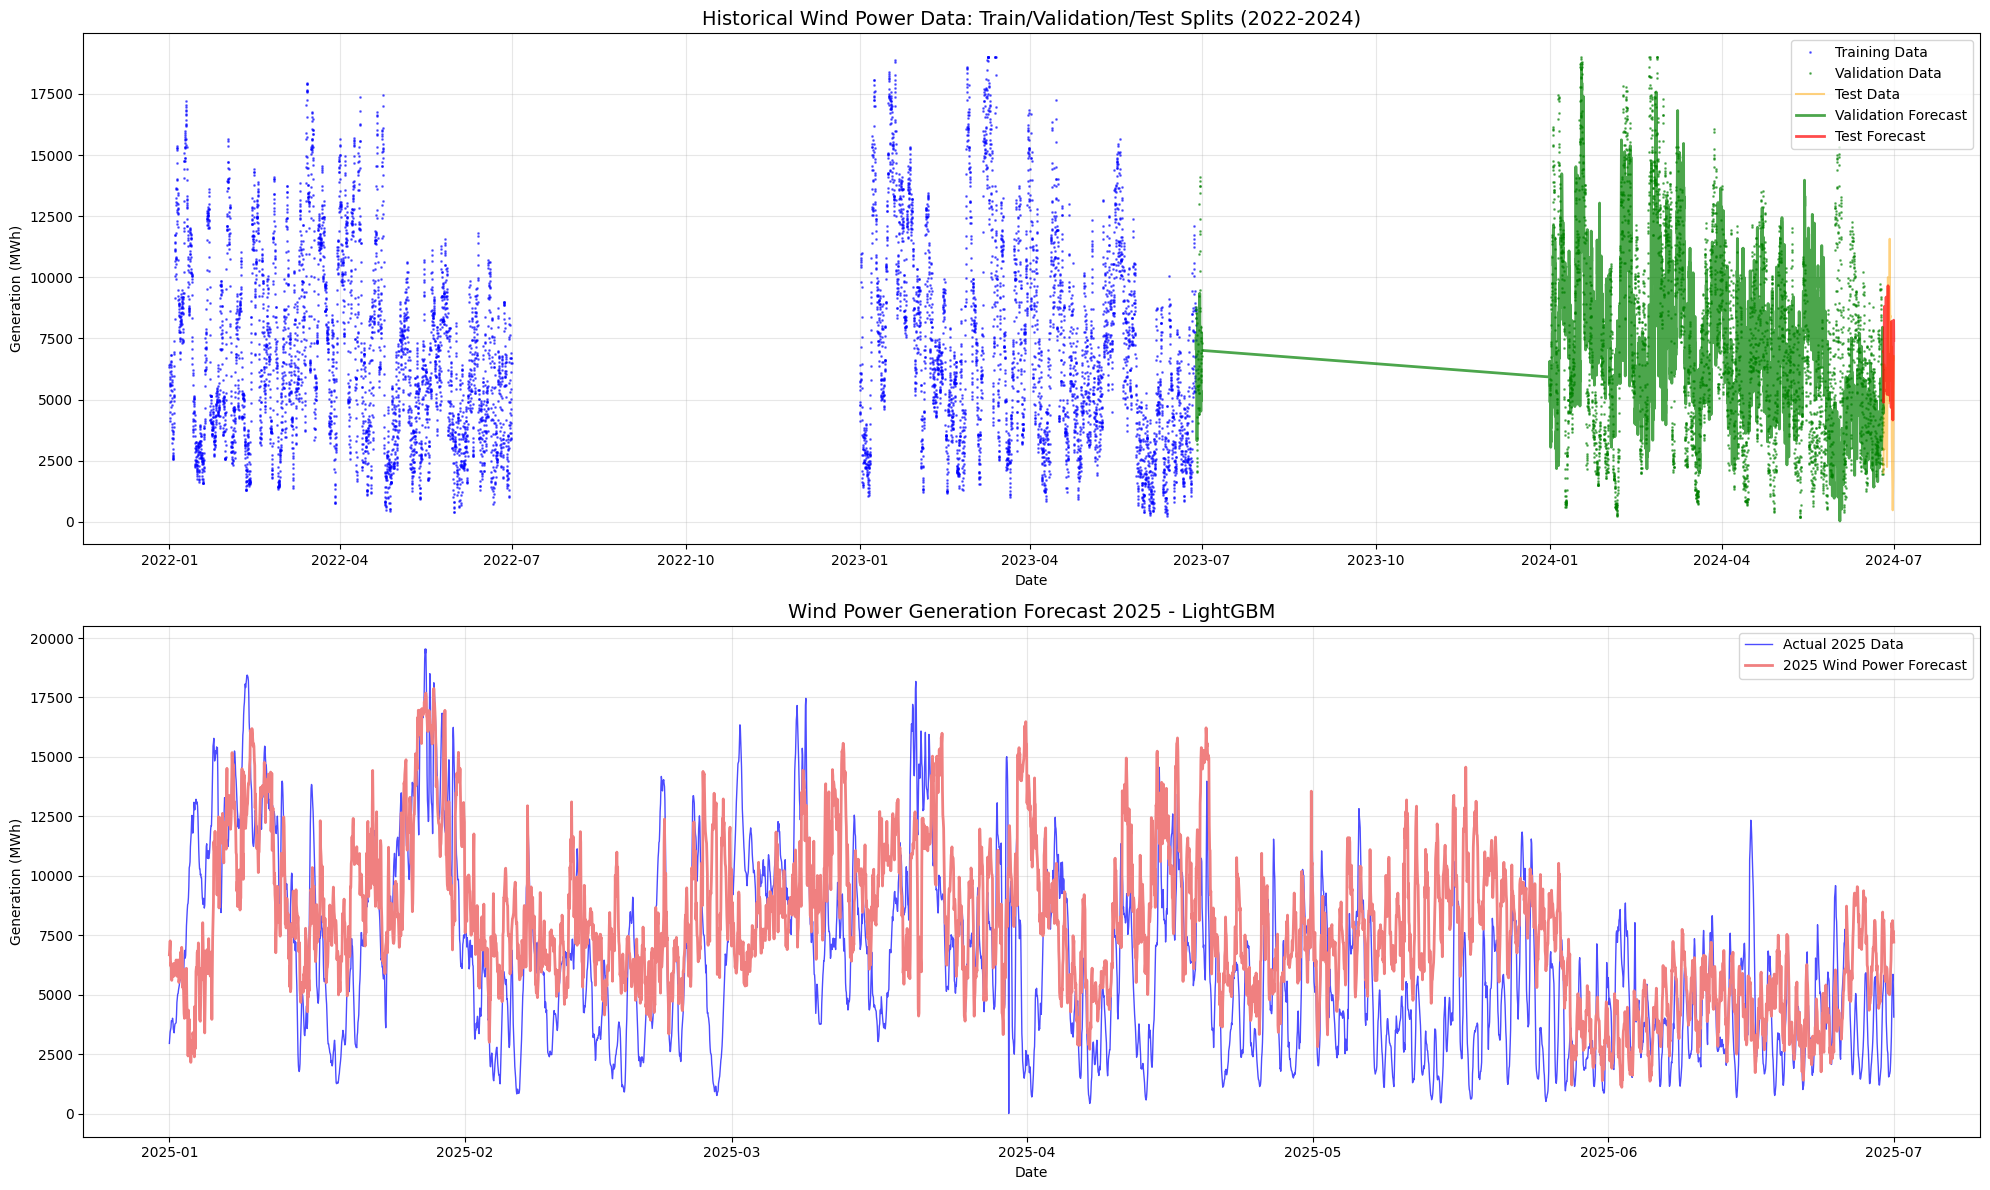

In [221]:
# Visualize train/val/test splits and model performance for wind power
fig, axes = plt.subplots(2, 1, figsize=(20, 12))

# Plot 1: Historical data with splits (Mar-Sep 2022-2024)
ax1 = axes[0]
ax1.plot(train_df['ds'], train_df['y'], 'b.', label='Training Data', alpha=0.5, markersize=2)
ax1.plot(val_df['ds'], val_df['y'], 'g.', label='Validation Data', alpha=0.5, markersize=2)
ax1.plot(test_df['ds'], test_df['y'], 'orange', label='Test Data', alpha=0.5, markersize=2)

# Add predictions on validation and test sets
ax1.plot(val_forecast['ds'], val_forecast['yhat'], 'g-', label='Validation Forecast', linewidth=2, alpha=0.7)
ax1.plot(test_forecast['ds'], test_forecast['yhat'], 'r-', label='Test Forecast', linewidth=2, alpha=0.7)

ax1.set_title('Historical Wind Power Data: Train/Validation/Test Splits (2022-2024)', fontsize=14)
ax1.set_xlabel('Date')
ax1.set_ylabel('Generation (MWh)')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: 2025 Forecast (Mar-Sep)
ax2 = axes[1]
ax2.plot(df_2025['ds'], df_2025['y'], 'blue', label='Actual 2025 Data', linewidth=1, alpha=0.7)
ax2.plot(forecast_2025['ds'], forecast_2025['yhat'], 'lightcoral', label='2025 Wind Power Forecast', linewidth=2)

ax2.set_title('Wind Power Generation Forecast 2025 - LSTM', fontsize=14)
ax2.set_xlabel('Date')
ax2.set_ylabel('Generation (MWh)')
ax2.legend(loc='upper right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



# Graph 1

In [222]:
# Export 2025 forecast (Mar-Sep) to CSV
forecast_export = forecast_2025[['ds', 'yhat']].copy()
forecast_export['timestamp'] = forecast_export['ds'].dt.strftime('%Y-%m-%d %H:%M:%S')
forecast_export = forecast_export[['timestamp', 'yhat']].rename(columns={
    'timestamp': 'Timestamp',
    'yhat': 'Forecast_Generation_MWh'
})

output_file = 'wind_forecast_2025_mar_sep_hourly.csv'
forecast_export.to_csv(output_file, index=False)
print(f"2025 forecast (March to September) exported to: {output_file}")
print(f"\nSummary statistics of 2025 Mar-Sep forecast:")
print(forecast_export.describe())

2025 forecast (March to September) exported to: wind_forecast_2025_mar_sep_hourly.csv

Summary statistics of 2025 Mar-Sep forecast:
       Forecast_Generation_MWh
count              4344.000000
mean               7903.278977
std                3128.456894
min                1102.838854
25%                5713.894034
50%                7528.690706
75%                9828.913518
max               17877.942726


In [223]:
# Load actual 2025 data for comparison
df_2025 = pd.read_csv("../Gen_data/Wind_Onshore_hourly_2025.csv")
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']

# 删除datetime列中2025/10/21 21:00:00之后的所有数据行
cutoff_datetime = pd.to_datetime('2025-10-21 20:00:00')
df_2025 = df_2025[df_2025['ds'] <= cutoff_datetime]

df_2025

,datetime,Area,Production Type,Generation (MWh),ds,y
0,2025/1/1 0:00,BZN|ES,Wind Onshore,2949.0,2025-01-01 00:00:00,2949.0
1,2025/1/1 1:00,BZN|ES,Wind Onshore,3222.0,2025-01-01 01:00:00,3222.0
2,2025/1/1 2:00,BZN|ES,Wind Onshore,3428.0,2025-01-01 02:00:00,3428.0
3,2025/1/1 3:00,BZN|ES,Wind Onshore,3526.0,2025-01-01 03:00:00,3526.0
4,2025/1/1 4:00,BZN|ES,Wind Onshore,3609.0,2025-01-01 04:00:00,3609.0
...,...,...,...,...,...,...
7048,2025/10/21 16:00,BZN|ES,Wind Onshore,12590.0,2025-10-21 16:00:00,12590.0
7049,2025/10/21 17:00,BZN|ES,Wind Onshore,13784.0,2025-10-21 17:00:00,13784.0
7050,2025/10/21 18:00,BZN|ES,Wind Onshore,13762.0,2025-10-21 18:00:00,13762.0
7051,2025/10/21 19:00,BZN|ES,Wind Onshore,13440.0,2025-10-21 19:00:00,13440.0


In [224]:
# Process 2025 data similar to training data
# The datetime column should already be in the correct format
df_2025['ds'] = pd.to_datetime(df_2025['datetime'])
df_2025['y'] = df_2025['Generation (MWh)']
df_2025 = df_2025[['ds', 'y']].sort_values('ds')

# Filter for March to September 2025 only
df_2025['month'] = df_2025['ds'].dt.month
df_2025 = df_2025[(df_2025['month'] >= 3) & (df_2025['month'] <= 9)].copy()
df_2025 = df_2025[['ds', 'y']]  # Keep only required columns

print(f"2025 actual data loaded (March to September):")
print(f"  Period: {df_2025['ds'].min()} to {df_2025['ds'].max()}")
print(f"  Total records: {len(df_2025)}")
print(f"  Data range: {df_2025['y'].min():.2f} to {df_2025['y'].max():.2f} MWh")

# Merge forecast with actual 2025 data (both are hourly)
comparison = pd.merge(
    forecast_2025[['ds', 'yhat']],
    df_2025[['ds', 'y']],
    on='ds',
    how='inner'
)

print(f"\nMatched records: {len(comparison)}")

# Calculate metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Calculate MAPE excluding very small values
threshold = 1000  # MWh
significant_mask = comparison['y'] >= threshold
if significant_mask.sum() > 0:
    mape = np.mean(np.abs((comparison['y'][significant_mask] - comparison['yhat'][significant_mask]) / comparison['y'][significant_mask])) * 100
else:
    mape = np.nan

print(f"\n2025 Forecast Performance Metrics:")
print("=" * 50)
print(f"MAE:  {mae:.2f} MWh")
print(f"RMSE: {rmse:.2f} MWh")
if not np.isnan(mape):
    print(f"MAPE (generation >= {threshold} MWh): {mape:.2f}%")
else:
    print(f"MAPE: N/A")

# Show data ranges
print(f"\nData ranges:")
print(f"  Actual values: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MWh")
print(f"  Forecasted values: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MWh")

2025 actual data loaded (March to September):
  Period: 2025-03-01 00:00:00 to 2025-09-30 23:00:00
  Total records: 5136
  Data range: 0.00 to 18174.00 MWh

Matched records: 2928

2025 Forecast Performance Metrics:
MAE:  3026.02 MWh
RMSE: 3839.11 MWh
MAPE (generation >= 1000 MWh): 82.55%

Data ranges:
  Actual values: 0.00 to 18174.00 MWh
  Forecasted values: 1102.84 to 16480.44 MWh


In [225]:
# Check for zero values in actual data
zero_counts = (comparison['y'] == 0).sum()
print(f"Number of zero values in actual data: {zero_counts}")

# Calculate metrics with handling for zero values
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

# Modified MAPE calculation excluding zero values
non_zero_mask = comparison['y'] != 0
mape = np.mean(np.abs((comparison['y'][non_zero_mask] - comparison['yhat'][non_zero_mask]) / comparison['y'][non_zero_mask])) * 100

print(f"\nMetrics (excluding zero values for MAPE):")
print(f"Mean Absolute Error (MAE): {mae:.2f} MW")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"Root Mean Square Error (RMSE): {rmse:.2f} MW")

# Show min/max values
print(f"\nData ranges:")
print(f"Actual values range: {comparison['y'].min():.2f} to {comparison['y'].max():.2f} MW")
print(f"Forecasted values range: {comparison['yhat'].min():.2f} to {comparison['yhat'].max():.2f} MW")

Number of zero values in actual data: 1

Metrics (excluding zero values for MAPE):
Mean Absolute Error (MAE): 3026.02 MW
Mean Absolute Percentage Error (MAPE): 95.06%
Root Mean Square Error (RMSE): 3839.11 MW

Data ranges:
Actual values range: 0.00 to 18174.00 MW
Forecasted values range: 1102.84 to 16480.44 MW


In [226]:
# Add hour of day for filtering daylight hours
comparison['hour'] = comparison['ds'].dt.hour

# Calculate installed capacity (using 95th percentile of actual values as proxy)
installed_capacity = comparison['y'].quantile(0.95)

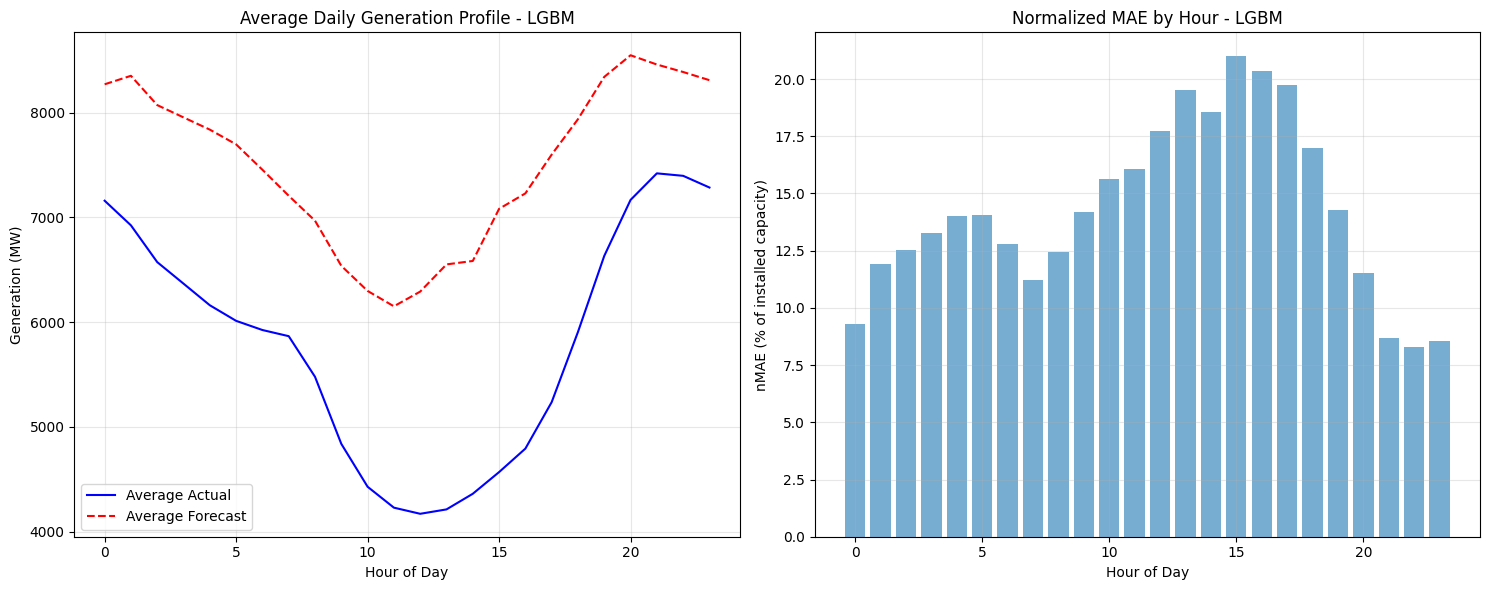

In [227]:
# Create hourly averages for error analysis
hourly_metrics = comparison.groupby('hour').agg({
    'y': 'mean',
    'yhat': 'mean'
}).reset_index()

hourly_metrics['mae'] = abs(hourly_metrics['y'] - hourly_metrics['yhat'])
hourly_metrics['nmae'] = hourly_metrics['mae'] / installed_capacity * 100

# Plot hourly performance
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(hourly_metrics['hour'], hourly_metrics['y'], 'b-', label='Average Actual')
plt.plot(hourly_metrics['hour'], hourly_metrics['yhat'], 'r--', label='Average Forecast')
plt.title('Average Daily Generation Profile - LSTM')
plt.xlabel('Hour of Day')
plt.ylabel('Generation (MW)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.bar(hourly_metrics['hour'], hourly_metrics['nmae'], alpha=0.6)
plt.title('Normalized MAE by Hour - LSTM')
plt.xlabel('Hour of Day')
plt.ylabel('nMAE (% of installed capacity)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Graph 2